In [1]:
cd /home/ubuntu/OTIV_ML_Challenge

/home/ubuntu/OTIV_ML_Challenge


In [2]:
!nvidia-smi
# Check size of cuda, make it free by running:
# !sudo kill -16223 PID
!pwd

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Fri Oct  8 12:47:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   77C    P0    32W /  70W |      0MiB / 15109MiB |      0%    

In [4]:
import os
import time
from glob import glob

import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from data import RailData
from model import build_unet
from loss import DiceLoss, DiceBCELoss
from Helper import seeding, create_dir, epoch_time
import torch
import torchvision
import torchvision.transforms as transforms

import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
import cv2,  subprocess
import math, base64, io, os, time, cv2
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from albumentations import HorizontalFlip, Rotate, Rotate, RandomBrightness, RandomBrightnessContrast
import albumentations as A
from albumentations.pytorch import ToTensorV2


""" Seeding """
seeding(42)

path = "Data"

""" Directories """
create_dir("files")

""" Load dataset """
train_x = sorted(glob(os.path.join(path,"Train","Images","*.jpg")))
train_y = sorted(glob(os.path.join(path,"Train","Masks","*.png")))

valid_x = sorted(glob(os.path.join(path,"Valid","Images","*.jpg")))

valid_y = sorted(glob(os.path.join(path,"Valid","Masks","*.png")))


data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
print(data_str)


""" Hyperparameters """

H = 512
W = 512
size = (H, W)

batch_size = 2
num_epochs = 10
lr = 0.0005

checkpoint_path = "Unet/files/checkpoint.pth"


"""Augmentation """

costoum_transform = A.Compose(
    [
        A.Resize(H,W),
#         A.HorizontalFlip(p=0.3),
#         A.Rotate(limit=15, p=0.8,always_apply=False),
# #         A.RandomBrightnessContrast(p=0.5,always_apply=False),
#         A.RandomSnow(brightness_coeff=1.5, always_apply=False, p=0.5),
#         A.RandomRain(p=0.5, always_apply=False),
#         A.RandomSunFlare(p=0.2, always_apply=False),
        ToTensorV2(),
    ]
)

""" Dataset and loader """

size = (H,W)
train_dataset = RailData(train_x, train_y, size)
valid_dataset = RailData(valid_x, valid_y,size)


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers = 1
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers = 1

)

 

Dataset Size:
Train: 1397 - Valid: 501



In [5]:
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss



In [6]:
device = torch.device('cuda')  
print(device)
model = build_unet()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn =   DiceBCELoss()

""" Training the model """
best_valid_loss = float("inf")

train_loss_data =[]
valid_loss_data = []

def trainer(checkpoint_path):
    
    best_valid_loss = float("inf")
    for epoch in range(num_epochs):
        start_time = time.time()
        

        train_loss = train(model, train_loader, optimizer, loss_fn, device)
        print("Train loss: ",train_loss)
        valid_loss = evaluate(model, valid_loader, loss_fn, device)
        print("Valid loss: ",train_loss)


        """ Saving the model """
        if valid_loss < best_valid_loss:
            data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
            print(data_str)

            best_valid_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
        data_str += f'\tTrain Loss: {train_loss:.3f}\n'
        train_loss_data.append(train_loss)
       
        data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
        valid_loss_data.append(valid_loss)
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        print(data_str)

cuda


In [7]:
trainer(checkpoint_path = "Unet/files/checkpoint.pth")

Train loss:  0.5406095790750053
Valid loss:  0.5406095790750053
Valid loss improved from inf to 0.2907. Saving checkpoint: Unet/files/checkpoint.pth
Epoch 0/9
----------
Epoch: 01 | Epoch Time: 10m 37s
	Train Loss: 0.541
	 Val. Loss: 0.291

Train loss:  0.2657595434397971
Valid loss:  0.2657595434397971
Valid loss improved from 0.2907 to 0.2651. Saving checkpoint: Unet/files/checkpoint.pth
Epoch 1/9
----------
Epoch: 02 | Epoch Time: 10m 38s
	Train Loss: 0.266
	 Val. Loss: 0.265

Train loss:  0.2304990648669064
Valid loss:  0.2304990648669064
Valid loss improved from 0.2651 to 0.2411. Saving checkpoint: Unet/files/checkpoint.pth
Epoch 2/9
----------
Epoch: 03 | Epoch Time: 10m 38s
	Train Loss: 0.230
	 Val. Loss: 0.241

Train loss:  0.21029699496519838
Valid loss:  0.21029699496519838
Epoch 3/9
----------
Epoch: 04 | Epoch Time: 10m 38s
	Train Loss: 0.210
	 Val. Loss: 0.252

Train loss:  0.19237160093773248
Valid loss:  0.19237160093773248
Epoch 4/9
----------
Epoch: 05 | Epoch Time: 10

In [8]:
print("Done!")

Done!


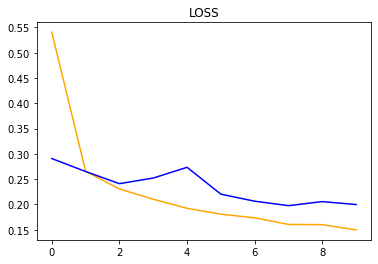

In [10]:
import matplotlib.pyplot as plt

plt.title('LOSS')

plt.plot(train_loss_data,color='Orange')
plt.plot(valid_loss_data,color='blue')

In [12]:
import os, time
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
import imageio
import torch
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

from model import build_unet
from Helper import create_dir, seeding

def calculate_metrics(y_true, y_pred):
    """ Ground truth """
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]

def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Folders """
    create_dir("results")

    """ Load dataset """
    test_x = sorted(glob("Data/Test_Real_Time/Images/*"))[:2]
    test_y = sorted(glob("Data/Test_Real_Time/Masks/*"))[:2]
   

    """ Hyperparameters """
    H = 512
    W = 512
    size = (W, H)
    checkpoint_path = "Unet/files/checkpoint.pth"

    """ Load the checkpoint """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = build_unet()
    model = model.to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
    time_taken = []
  
    for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image """
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## (512, 512, 3)
        image = cv2.resize(image, size)
        print(image.shape)
        x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
        x = x/255.0
        x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
        x = x.astype(np.float32)
        x = torch.from_numpy(x)
        x = x.to(device)

        """ Reading mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
        mask = cv2.resize(mask, size)
        y = np.expand_dims(mask, axis=0)            ## (1, 512, 512)
        y = y/255.0
        y = np.expand_dims(y, axis=0)               ## (1, 1, 512, 512)
        y = y.astype(np.float32)
        y = torch.from_numpy(y)
        y = y.to(device)

        with torch.no_grad():
            """ Prediction and Calculating FPS """
            start_time = time.time()
            pred_y = model(x)
            pred_y = torch.sigmoid(pred_y)
           
            total_time = time.time() - start_time
            time_taken.append(total_time)


            score = calculate_metrics(y, pred_y)
            metrics_score = list(map(add, metrics_score, score))
            pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
          
            pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
            pred_y = pred_y > 0.5
            pred_y = np.array(pred_y, dtype=np.uint8)

        """ Saving masks """
        ori_mask = mask_parse(mask)
        pred_y = mask_parse(pred_y)
        line = np.ones((size[1], 10, 3)) * 128

        cat_images = np.concatenate(
            [image, line, ori_mask, line, pred_y * 255], axis=1
        )
        cv2.imwrite(f"results/{name}.png", cat_images)
        
         

    jaccard = metrics_score[0]/len(test_x)
    f1 = metrics_score[1]/len(test_x)
    recall = metrics_score[2]/len(test_x)
    precision = metrics_score[3]/len(test_x)
    acc = metrics_score[4]/len(test_x)
    print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f}")

    fps = 1/np.mean(time_taken)
    print("FPS: ", fps)

  0%|          | 0/2 [00:00<?, ?it/s]

(512, 512, 3)


 50%|█████     | 1/2 [00:00<00:00,  1.98it/s]

(512, 512, 3)


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

Jaccard: 0.9784 - F1: 0.9891 - Recall: 0.9875 - Precision: 0.9907 - Acc: 0.9992
FPS:  70.61950061455053


In [ ]:
import time
for i in range(100000):
    print(i)
    time.sleep()
    

In [81]:
torch.cuda.empty_cache()

In [174]:
from albumentations import HorizontalFlip, Rotate, Rotate, RandomBrightness, RandomBrightnessContrast

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.2,always_apply=False),
        A.HorizontalFlip(p=0.3),
        A.Rotate(limit=15, p=0.8,always_apply=False),
        A.RandomBrightness(p=0.5,always_apply=False),
        A.RandomSnow(brightness_coeff=1.5, always_apply=False, p=0.5),
        A.RandomRain(p=0.5, always_apply=False),
        A.RandomSunFlare(p=0.2, always_apply=False),

        ToTensorV2(),
    ]
)


(720, 640)
(3, 512, 512)
(512, 512, 3)


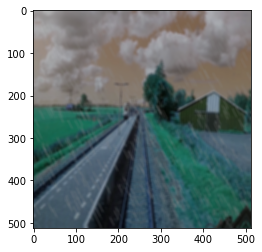

In [205]:
import matplotlib.pyplot as plt

from PIL import Image
train_x = sorted(glob(os.path.join(path,"Train","Images","*.jpg")))
train_y = sorted(glob(os.path.join(path,"Train","Masks","*.png")))


size =(720,640)
i,m = RailData(train_x,train_y,size,transform=train_transform)[0]
arr = (i.detach().numpy())
print(arr.shape)
arr = np.transpose(arr, (1, 2, 0))
print(arr.shape)
plt.imshow((arr))


(720, 640)


(tensor([[[138, 138, 138,  ..., 150, 150, 149],
          [138, 138, 138,  ..., 149, 149, 149],
          [138, 138, 138,  ..., 149, 149, 149],
          ...,
          [ 23,  23,  21,  ...,  73,  72,  73],
          [ 22,  22,  21,  ...,  71,  70,  70],
          [ 23,  22,  20,  ...,  70,  71,  69]],
 
         [[135, 135, 135,  ..., 147, 147, 147],
          [135, 135, 135,  ..., 147, 147, 147],
          [135, 135, 135,  ..., 147, 147, 147],
          ...,
          [ 25,  25,  23,  ...,  93,  94,  93],
          [ 25,  24,  23,  ...,  91,  90,  90],
          [ 25,  24,  23,  ...,  90,  91,  88]],
 
         [[140, 140, 140,  ..., 147, 147, 147],
          [140, 140, 140,  ..., 147, 147, 147],
          [140, 140, 140,  ..., 147, 147, 147],
          ...,
          [ 22,  22,  20,  ..., 105, 105, 105],
          [ 22,  21,  20,  ..., 103, 102, 102],
          [ 22,  21,  20,  ..., 102, 102, 100]]], dtype=torch.uint8),
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 